In [1]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./trajopt/constraint.jl")
include("./trajopt/costfunction.jl")
include("./trajopt/scaling.jl")
include("./trajopt/scp.jl")
include("./trajopt/discretize.jl")
using Plots

In [2]:
ix = 12
iu = 4
N = 10
dynamics = QuadrotorDynamics()
g = dynamics.g
m = dynamics.m
J_x = dynamics.Jx
J_y = dynamics.Jy
J_z = dynamics.Jz

1.0

In [3]:
OS_translation = 5/100
Tp_translation = 5
Ts_translation = 10 

OS_rotation = 5/100
Tp_rotation = 5
Ts_rotation = 10

zeta_translation = - log(OS_translation) / sqrt(pi^2 + log(OS_translation)^2)
wn_translation = 4.0 / zeta_translation / Ts_translation

zeta_rotation = - log(OS_rotation) / sqrt(pi^2 + log(OS_rotation)^2)
wn_rotation = 4 / zeta_rotation / Ts_rotation

kR = 300 
komega = 10

kx = 0.3
kv = 0.8

0.8

In [4]:
function hat_map(v::Vector)
    return [0.0 -v[3] v[2];
            v[3] 0.0 -v[1];
            -v[2] v[1] 0.0]
end
function vee_map(skew::Matrix)
    vec = 1/2 .* [skew[3,2]-skew[2,3];skew[1,3]-skew[3,1];skew[2,1]-skew[1,2]]
    return vec
end

function dir_cosine(q)
    C_B_I = [1 - 2 * (q[2] ** 2 + q[3] ** 2), 2 * (q[1] * q[2] + q[0] * q[3]), 2 * (q[1] * q[3] - q[0] * q[2]);
    2 * (q[1] * q[2] - q[0] * q[3]), 1 - 2 * (q[1] ** 2 + q[3] ** 2), 2 * (q[2] * q[3] + q[0] * q[1]);
    2 * (q[1] * q[3] + q[0] * q[2]), 2 * (q[2] * q[3] - q[0] * q[1]), 1 - 2 * (q[1] ** 2 + q[2] ** 2)]
    return C_B_I'
end


function get_R(e::Vector)
    phi = e[1]
    theta = e[2]
    psi = e[3]

    C_B_I = zeros(3,3)
    C_B_I[1,1] = cos(psi) * cos(theta)
    C_B_I[1,2] = sin(psi) * cos(theta)
    C_B_I[1,3] = -sin(theta)
    C_B_I[2,1] = -sin(psi)*cos(phi) + cos(psi)*sin(theta)*sin(phi)
    C_B_I[2,2] = cos(psi)*cos(phi) + sin(psi)*sin(theta)*sin(phi)
    C_B_I[2,3] = cos(theta)*sin(phi)
    C_B_I[3,1] = sin(psi)*sin(phi) + cos(psi)*sin(theta)*cos(phi)
    C_B_I[3,2] = -cos(psi)*sin(phi)+sin(psi)*sin(theta)*cos(phi)
    C_B_I[3,3] = cos(theta)*cos(phi)
    return C_B_I' # C_I_B
end

get_R (generic function with 1 method)

In [36]:
frequency = 2*pi/20
function geometric_control(t::Float64,x::Vector)
    rN = x[1]
    rE = x[2]
    rD = x[3]

    vx = x[4]
    vy = x[5]
    vz = x[6]

    phi = x[7]
    theta = x[8]
    psi = x[9]

    p = x[10]
    q = x[11]
    r = x[12]
    omega = [p;q;r]
    J = [J_x 0 0;0 J_y 0;0 0 J_z]

    # R
    R = get_R([phi,theta,psi])

    # desired position (hard coding)
    Ddes = - 5.0
    Ddes_dot = 0.0

    Ndes = 2 * cos(frequency*t)
    Ndes_dot = - 2 * frequency * sin(frequency*t)
    Ndes_ddot = - 2 * frequency^2 * cos(frequency*t)
    Edes = 2 * sin(frequency*t)
    Edes_dot = 2 * frequency * cos(frequency*t)
    Edes_ddot = - 2 * frequency^2 * sin(frequency*t)

    psi_des = deg2rad(10)
    psi_des_dot = 0.0

    # errors
    ex = x[1:3] - [Ndes;Edes;Ddes]
    ev = x[4:6] - [Ndes_dot;Edes_dot;Ddes_dot]

    # total thrust
    xddot_des = [Ndes_ddot;Edes_ddot;0.0]
    Fd = - (- kx * ex - kv * ev - m.*g.*[0;0;1] + m * xddot_des)
    Fz = dot(Fd,R * [0;0;1])

    # desired attitudes
    if norm(Fd) < 1e-8
        @error("Fd is too small")
    end
    b3d = Fd ./ norm(Fd)
    b1d = [cos(psi_des);sin(psi_des);0]
    b2d = cross(b3d,b1d)
    b2d = b2d ./ norm(b2d)
    Rd = zeros(3,3)
    Rd[:,1] = cross(b2d,b3d)
    Rd[:,2] = b2d
    Rd[:,3] = b3d
    Rd_dot = get_R(zeros(3))
    omega_des = zeros(3)
    omega_dot_des = zeros(3)

    # errors
    eR = 0.5 * vee_map(Rd'*R - R'*Rd)
    e_omega = omega - R'*Rd*omega_des

    M = (-kR .* eR - komega .* e_omega) + cross(omega,J*omega) - J*(hat_map(omega)*R'*Rd*omega_des - R'*Rd*omega_dot_des)

    return Fz,M
end

function control_systems!(f,x,p,t)
    dt = p[1]
    state = x[1:12]

    # geometric control
    Fz,M = geometric_control(dt*t,x)

    control_input = zeros(iu)
    control_input[1] = Fz
    control_input[2:end] = M

    f[1:ix] .= dt*forward(dynamics,state,control_input)
    # f[ix+1:ix+3] .= dt*att_err
end

control_systems! (generic function with 1 method)

In [37]:
tspan = (0,1)
saveat = collect(range(0,1,501))
x0 = [0.;0.;0.; 0.;0.;0.; 0.;0.;0.; 0.;0.;0.;
        # 0.;0.;0. # attiude error integration
        ]
T = 30
prob = ODEProblem(control_systems!,x0,tspan,(T))
sol = solve(prob, Tsit5(),saveat=saveat,reltol=1e-9, abstol=1e-9;verbose=false);
tode = sol.t
xode = stack(sol.u)
tplot = T .* tode

501-element Vector{Float64}:
  0.0
  0.06
  0.12
  0.18
  0.24
  0.3
  0.36
  0.42
  0.48
  0.5399999999999999
  ⋮
 29.52
 29.58
 29.64
 29.7
 29.759999999999998
 29.82
 29.88
 29.94
 30.0

In [38]:
Ndes = 2 .* cos.(frequency.*tplot)
Edes = 2 .* sin.(frequency.*tplot);

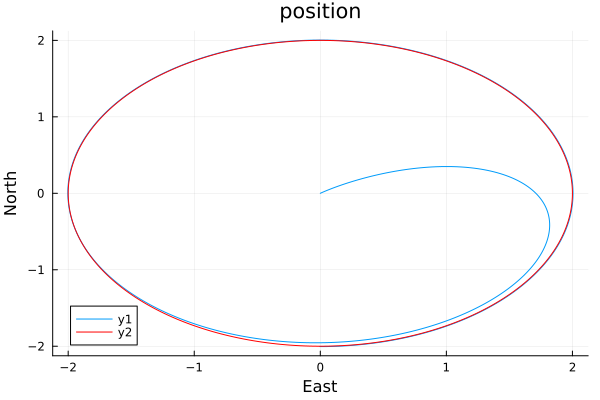

In [39]:
plot(xode[2,:],xode[1,:],title="position")
plot!(Edes,Ndes,color=:red)
xlabel!("East")
ylabel!("North")

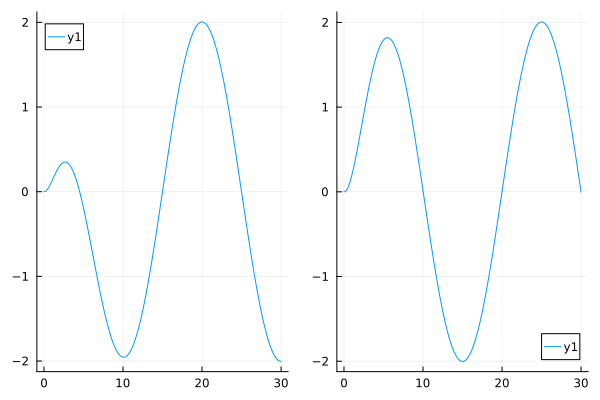

In [40]:
px = plot(tplot,xode[1,:])
py = plot(tplot,xode[2,:])
plot(px,py)

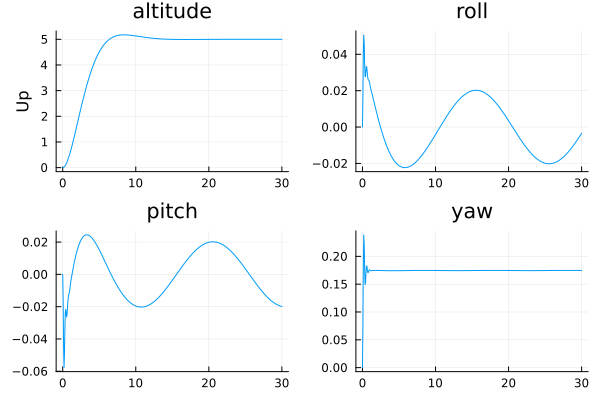

In [41]:
pz = plot(tplot,- xode[3,:],title="altitude")
pz = ylabel!("Up")

p_phi = plot(tplot,xode[7,:],title="roll")
p_theta = plot(tplot,xode[8,:],title="pitch")
p_psi = plot(tplot,xode[9,:],title="yaw")
plot(pz, p_phi, p_theta, p_psi, layout = (2, 2), legend = false)

In [31]:
anim = Animation()

Animation("/var/folders/zh/8dk8mcb12vs7vp_rqg6sj_780000gn/T/jl_qQbh1m", String[])

In [32]:
for idx in 1:length(tplot)
    plot(xode[2,1:idx],xode[1,1:idx],label="quadrotor",title="position",aspect_ratio=1,size=(500,500))
    plot!(Edes[1:idx],Ndes[1:idx],color=:red,label="desired")
    scatter!([xode[2,idx]],[xode[1,idx]],makershape=:circle,markersize=5,color=:blue,label="")
    scatter!([Edes[idx]],[Ndes[idx]],makershape=:circle,markersize=5,color=:red,label="")
    xlims!(-2.5, 2.5)
    ylims!(-2.5, 2.5)
    xlabel!("East")
    ylabel!("North")
    frame(anim)
end

┌ Info: Saved animation to /Users/taewankim/Documents/Code/Personal/Funnel_CTCS/data_image/SO3_quadrotor.gif
└ @ Plots /Users/taewankim/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/Users/taewankim/Documents/Code/Personal/Funnel_CTCS/data_image/SO3_quadrotor.gif")
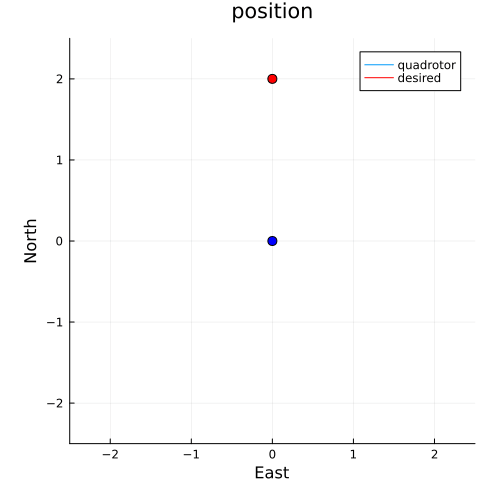

In [33]:
gif(anim, "./data_image/SO3_quadrotor.gif", fps=1/tplot[2])

In [ ]:
1/tplot[2]